In [490]:
%matplotlib inline
import os
import pandas as pd
import json
import folium
import numpy as np
import matplotlib.pyplot as plt
import datetime, time
import seaborn as sns
import sklearn
from sklearn import tree, ensemble
from sklearn.cross_validation import KFold
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_val_score, GridSearchCV
from sklearn import datasets, linear_model
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn import svm

from scipy import stats

In [491]:
data_dir = 'data/wrangled_data/'

In [492]:
def select_rows(df,from_col,row_list):
    df = df.dropna()
    df = df[df[from_col].str.contains(row_list)].set_index(from_col)
    return df

def get_income(wage_df):
    swiss = float(wage_df.loc[wage_df.index.str.contains('Swiss')].values[0][0])/float(wage_df.loc[wage_df.index.str.contains('TOTAL')].values[0][0])
    foreign = float(wage_df.loc[wage_df.index.str.contains('Foreigners')].values[0][0])/float(wage_df.loc[wage_df.index.str.contains('TOTAL')].values[0][0])
    return swiss, foreign

def get_med_income_df():
    region = ['central','east','lake_ge','mittelland','north','ti','zh']
    use_rows = 'TOTAL|Swiss|Foreigners'
    med_income = pd.read_csv('med_incomes.csv')
    med_income16 = med_income.loc[:,med_income.columns.isin(['Name','2016','region'])]
    wages_16 = []
    for r in region:
        wages_16.append(pd.read_csv(data_dir+'wages2016'+r+'.csv', usecols=['Residents','total_median']).dropna(how='all').rename(columns={'Residents': 'Residents_'+r}))
    for i in range(len(wages_16)):
        wages_16[i] = select_rows(wages_16[i],'Residents_'+region[i], use_rows)
    swiss = []
    foreign = []
    for reg in wages_16:
        x, y = get_income(reg)
        swiss.append(x)
        foreign.append(y)
    med_income16['Swiss_income'] = np.nan
    med_income16['Foreign_income'] = np.nan
    for reg, sw, fo in zip(region,swiss,foreign):
        med_income16['Swiss_income'] = med_income16.apply(lambda r: (r['2016'] * sw * 100) if r['region'] == reg else r['Swiss_income'], axis=1)
        med_income16['Foreign_income'] = med_income16.apply(lambda r: (r['2016'] * fo * 100) if r['region'] == reg else r['Foreign_income'], axis=1)
    med_income16 = med_income16.drop('2016', axis=1)
    return med_income16

def get_household_df():
    cols = ['Commune','1HH','2HH','3HH','4HH','5HH','6HH']
    rename_cols = {'1HH': '1', '2HH': '2', '3HH': '3', '4HH': '4', '5HH': '5', '6HH': '6'}
    df = pd.read_csv(data_dir + 'hh_sizes2016.csv', usecols=cols)
    if df.iloc[0][1] > 1000000:
        df = df.drop(0)
    df = df.set_index('Commune', drop=True)
    df.rename(columns=rename_cols, inplace=True)
    return df

In [493]:
def get_pop(df):
    df['Foreigners_pop'] = df.apply(lambda row: row['Population'] * (row["Ausländer in %"] / 100), axis=1)
    df['Swiss_pop'] = df.apply(lambda row: row['Population'] - row['Foreigners_pop'], axis=1)
    df['Swiss'] = 1
    df = df.drop(['Population',"Ausländer in %"], axis=1)
    return df

def get_region(df):
    region_list = ['central','east','lake_ge','mittelland','north','ti','zh']
    r = []
    for region in df['region']:
        for i, reg in enumerate(region_list,1):
            if region == reg:
                r.append(i)
    return r

def get_Swiss():
    use_cols = ['Gemeindename',"Ausländer in %","Bevölkerungs-dichte pro km²","Durchschnittliche Haushaltsgrösse in Personen",'Anzahl Privathaushalte']
    df_income = get_med_income_df()
    df_hh = get_household_df()
    df_swfo = pd.read_csv('data/foreignswiss.csv', usecols=use_cols).drop(0)
    cols_drop = ['Gemeindename', 'Name']
    #columns_drop = ['2016','Kleine Rechtsparteien','Rohe Heiratssziffer','Rohe Scheidungsziffer','Rohe Geburtenziffer','Rohe Sterbeziffer','PdA/Sol.','EVP/CSP','GLP','BDP','GPS','Neu gebaute Wohnungen pro 1000 Einwohner','Sozialhilfequote','Leerwohnungs-ziffer','im 1. Sektor','im 2. Sektor','im 3. Sektor','im 1. Sektor.1','im 2. Sektor.1','im 3. Sektor.1']
    df_melt = pd.melt(df_hh.reset_index(), id_vars=['Commune'], value_vars=['1','2','3','4','5','6'], var_name='HH_size', value_name='Population')
    df_melt = df_melt.set_index('Commune', drop=True).sort_values('Commune', ascending=True)
    com_merged = pd.merge(df_swfo,df_income,left_on='Gemeindename', right_on='Name')
    df_merged = com_merged.merge(df_melt, left_on='Gemeindename', right_index=True).drop(columns= cols_drop, axis=1)
    df = df_merged.convert_objects(convert_numeric=True).fillna(0)
    df_swiss = get_pop(df)
    region_num = get_region(df_swiss)
    df_swiss['region_num'] = region_num
    df_swiss = df_swiss.drop('region', axis=1)
    df_for = df_swiss.copy()
    df_swiss = df_swiss.rename(columns={'Swiss_pop': "population", 'Swiss_income': "income"}).drop(['Foreign_income', 'Foreigners_pop'], axis=1)
    df_for['Swiss'] = 0
    df_for = df_for.rename(columns={'Foreigners_pop': "population", 'Foreign_income': "income"}).drop(['Swiss_income', 'Swiss_pop'], axis=1)
    df = pd.concat([df_swiss, df_for])
    return df

def get_X_Y(df):
    Y = df.HH_size
    X = df.drop(columns='HH_size', axis=1)
    return X, Y

def get_mean(region_num,cols, swiss):
    df_reg_list = []
    for ind, item in enumerate(X['region_num']):
        if item == region_num:
            df_reg_list.append(X.iloc[ind])
    df = pd.DataFrame(df_reg_list)
    df = df.loc[df['Swiss'] == swiss]
    return df[cols].mean()

def pred_HH(income, swiss, region):
    #Region number from 1 to 7
    reg_dict = ['central','east','lake_ge','mittelland','north','ti','zh']
    cols = ['Bevölkerungs-dichte pro km²','Anzahl Privathaushalte', 'Durchschnittliche Haushaltsgrösse in Personen', 'income', 'population', 'Swiss','region_num']
    data = [(get_mean(region,cols[0], swiss), get_mean(region,cols[1], swiss), get_mean(region,cols[2], swiss), income, get_mean(region,cols[4], swiss), swiss, region)]
    df = pd.DataFrame(data, columns=cols)
    CV_rfr = RandomForestClassifier(
            n_estimators= 100, 
            max_depth=10
            )
    CV_rfr.fit(X, Y)
    print(CV_rfr.predict(df))

def get_hh_pred(income, Swiss):
    #Taking the best parameters from the Random Forest Classifier and Grid Search
    CV_rfr = RandomForestClassifier(
                n_estimators= 100, 
                max_depth=10
                )
    CV_rfr.fit(X_train, y_train)
    
    cols = ['Bevölkerungs-dichte pro km²','Anzahl Privathaushalte', 'Durchschnittliche Haushaltsgrösse in Personen', 'income', 'population', 'Swiss','region_num']
    #test = pd.DataFrame([{'Bevölkerungs-dichte pro km²': np.nan, 'Anzahl Privathaushalte':np.nan, 'Durchschnittliche Haushaltsgrösse in Personen': np.nan, 'income': income, 'population': np.nan, 'Swiss': Swiss}])
    
    # Set threshold and define linspace function, define threshold application
    region = [1,2,3,4,5,6,7]
    predicton = []
    for i in region:
        data = [(get_mean(i,cols[0], Swiss), get_mean(i,cols[1], Swiss), get_mean(i,cols[2], Swiss), income, get_mean(i,cols[4], Swiss), Swiss, i)]
        test = pd.DataFrame(data, columns=cols)
        pred = CV_rfr.predict(test)
        predicton.append(pred)
    
    # Plot the performance scores with respect to its threshold for all four properties
    # Plot the Adopted part with the threshold
    plt.figure(figsize=(12, 8))
    plt.xlabel("Region")
    plt.ylabel("Household size")
    plt.plot(region, predicton, label='household size')
    plt.savefig('randomforest_Region_'+str(Swiss)+'_'+str(income)+'.png', dpi=200)
    
def random_forest(X_train, y_train, X_test, y_test, estimator):
    #Taking the accuracy for the estimator passed with max_depth 10
    CV_rfr = RandomForestClassifier(
                    n_estimators= estimator, 
                    max_depth=10
                    )
    CV_rfr.fit(X_train, y_train)
    prediction = CV_rfr.predict(X_test)
    accuracy = accuracy_score(y_test, prediction)
    return accuracy

def get_random_estimators():
    # Set threshold and define linspace function, define threshold application
    n_estimators = np.linspace(5, 200, num=50, dtype='int', endpoint=True)
    accuracy = []
    for i in n_estimators:
        acc = random_forest(X_train, y_train, X_test, y_test, i)
        accuracy.append(acc)
    
    # Plot the performance scores with respect to its threshold for all four properties
    # Plot the Adopted part with the threshold
    plt.figure(figsize=(12, 8))
    plt.title('Random Forest Predictor for max_depth = 10',fontsize=15)
    plt.xlabel("n_estimators")
    plt.ylabel("Accuracy")
    ymax = max(accuracy)
    xpos = accuracy.index(ymax)
    xmax = n_estimators[xpos]
    plt.plot(xmax, ymax, 'ro')
    plt.annotate([np.round(xmax,3),np.round(ymax,3)], 
                 xy=(xmax, ymax))
    plt.plot(n_estimators, accuracy, label='accuracy')
    plt.savefig('randomforest_accuracy.png',dpi=200)


In [494]:
swiss_foreign = get_Swiss()
X, Y = get_X_Y(swiss_foreign)

/Users/yev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/yev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/yev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

In [495]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [457]:
rfc = RandomForestClassifier() 

estimators = [8, 16, 32,64, 80, 100, 120, 140, 160, 180]
depth = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

# Use a grid over parameters of interest
param_grid = { 
           "n_estimators" : estimators,
           "max_depth" : depth
            }
for i in depth:
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)

{'max_depth': 10, 'n_estimators': 100}


In [496]:
CV_rfr = RandomForestClassifier(
                    n_estimators= 100, 
                    max_depth=10
                    )
CV_rfr.fit(X_train, y_train)
prediction = CV_rfr.predict(X_test)
accuracy_score(y_test, prediction)

0.35096754057428214

In [503]:
pred_HH(6000, 1, 7)

[4]


In [504]:
pred_HH(6000, 0, 7)

[3]


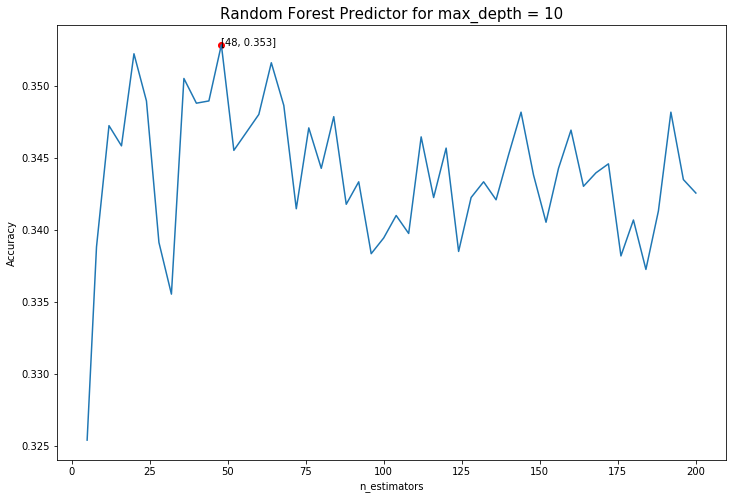

In [505]:
get_random_estimators()